In [1]:
from IPython.display import clear_output
# !pip3 install pandas openpyxl
clear_output()

In [8]:
import pandas as pd
df = pd.read_excel("controls.xlsx" , engine='openpyxl')

In [9]:
df.shape

(1076, 2)

In [10]:
df.head()

classification  cars_washed
0         Corner        33736
1         Corner        21077
2         Inside        25862
3         Corner        36381
4         Inside        29234

In [11]:
columns_list = df.columns.tolist()
columns_list

['classification', 'cars_washed']

In [12]:
df.describe()

cars_washed
count    1076.000000
mean    71490.586431
std     55035.902336
min      1059.000000
25%     26773.500000
50%     60377.000000
75%    102610.500000
max    321947.000000

In [16]:
df['classification'].value_counts()

classification
Corner    865
Inside    210
ERROR       1
Name: count, dtype: int64

In [17]:
from scipy import stats

# (1) Drop the lone “ERROR” row if you want clean groups:
df2 = df[df['classification'].isin(['Corner','Inside'])]

# (2) Extract each group’s values:
corner = df2.loc[df2['classification']=='Corner','cars_washed']
inside = df2.loc[df2['classification']=='Inside','cars_washed']

# (3) Run one‑way ANOVA:
F, p_value = stats.f_oneway(corner, inside)
print(f"F = {F:.3f}, p = {p_value:.3e}")

# (4) Compute group means to see direction:
print(df2.groupby('classification')['cars_washed'].agg(['mean','std','count']))


F = 1.893, p = 1.692e-01
                        mean           std  count
classification                                   
Corner          72634.609249  55110.575379    865
Inside          66809.238095  54738.426563    210


In [13]:
def remove_outliers_from_df(df, columns=None):
    """
    Removes outliers from specified columns of a DataFrame using the IQR method.
    If no columns are specified, applies to all numeric columns.

    Returns a new DataFrame with outliers removed row-wise.
    """
    df_clean = df.copy()
    
    if columns is None:
        columns = df.select_dtypes(include='number').columns

    for col in columns:
        if col not in df_clean.columns:
            continue
        q1 = df_clean[col].quantile(0.25)
        q3 = df_clean[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]

    return df_clean

In [14]:
df_clean= remove_outliers_from_df(df, numeric_cols)

In [15]:
# df_clean= df

In [16]:
# df_clean.to_csv("df_clean_v3.1_7min.csv", index=False)

In [17]:
len(df_clean)

536

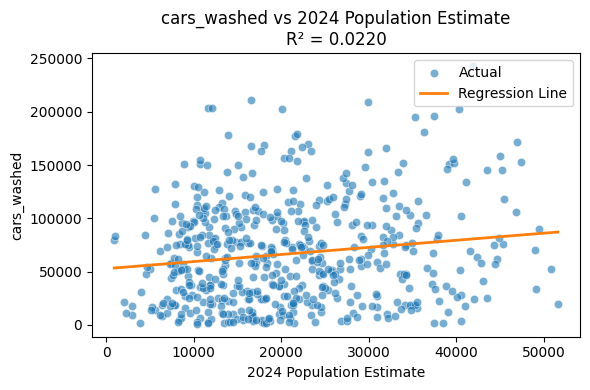

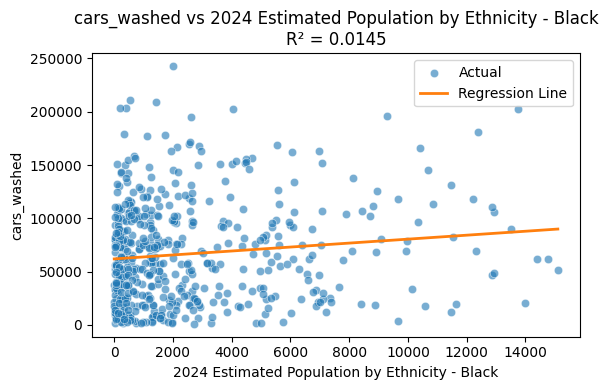

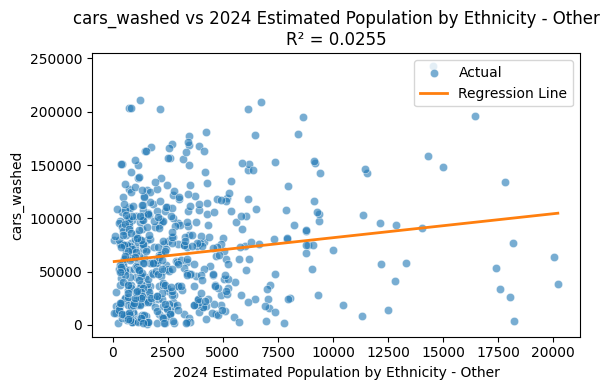

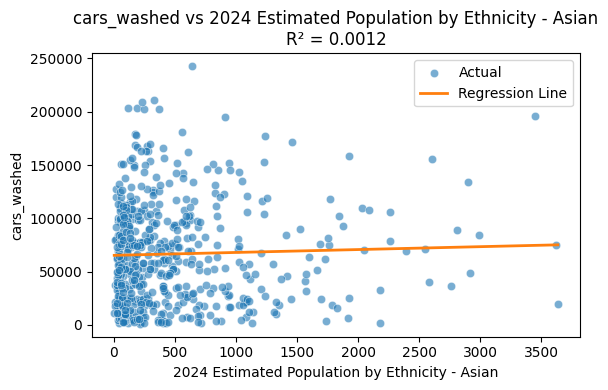

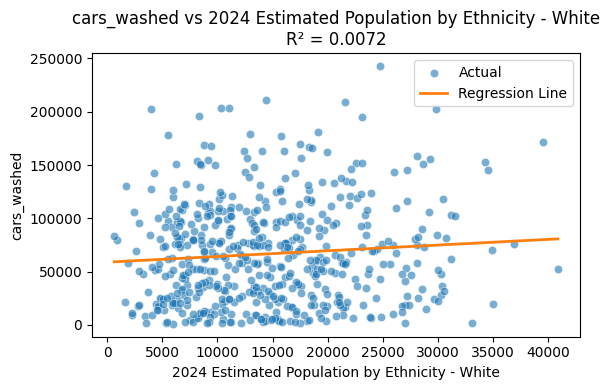

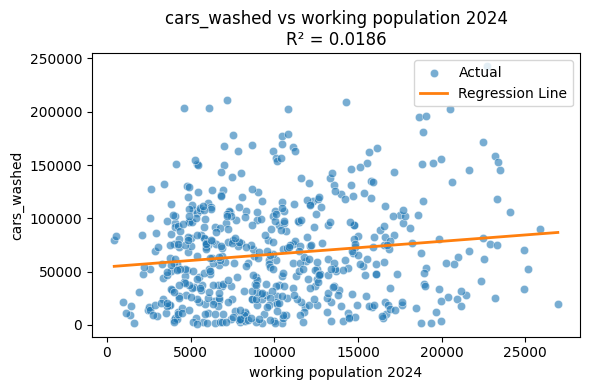

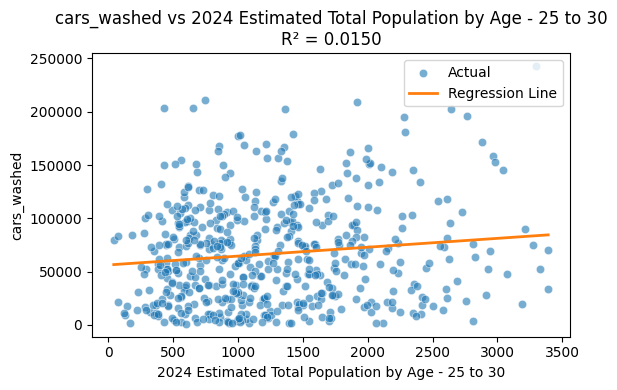

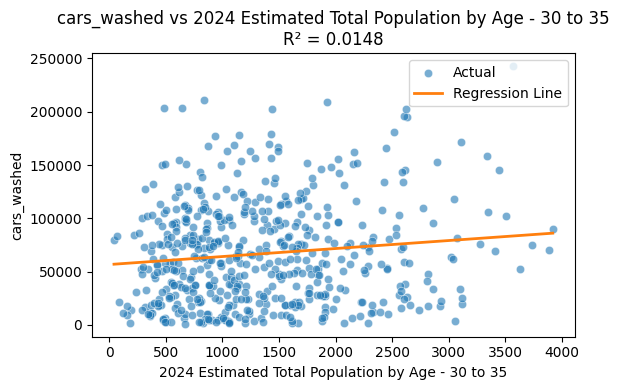

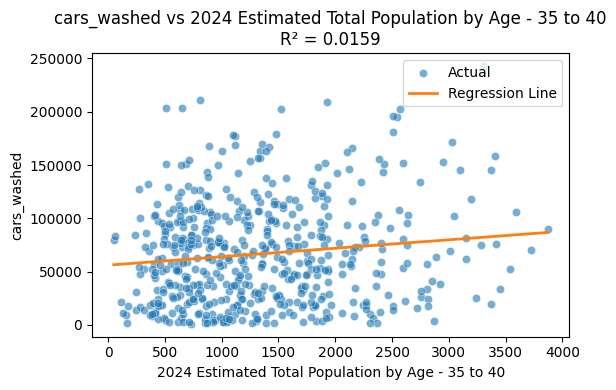

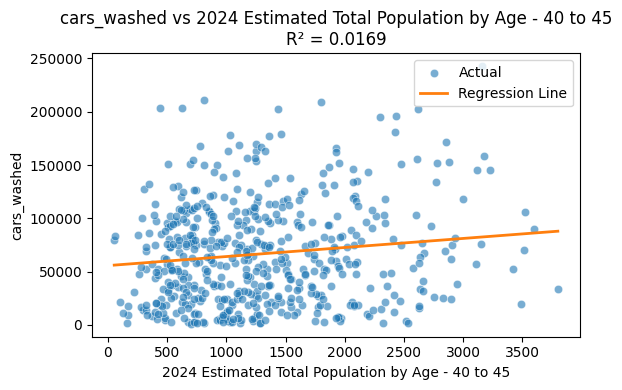

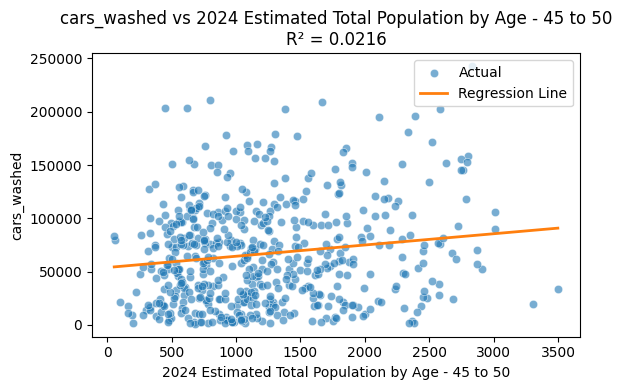

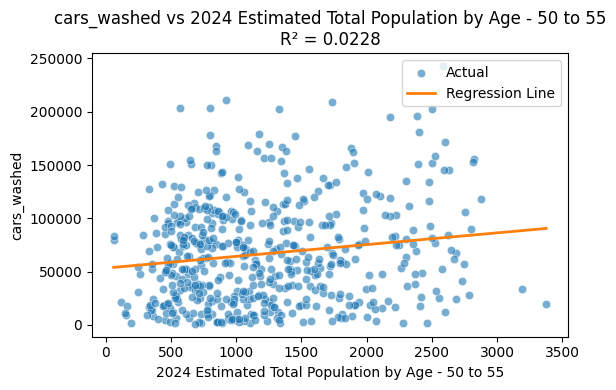

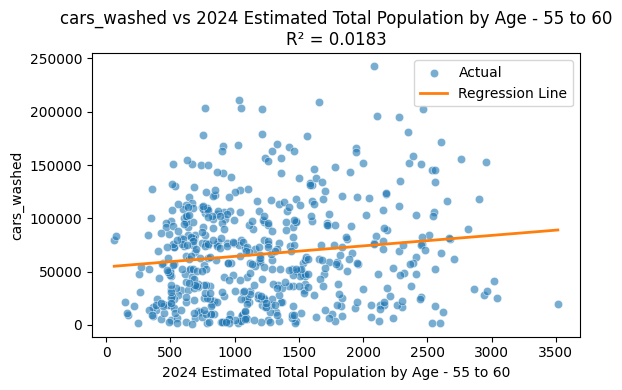

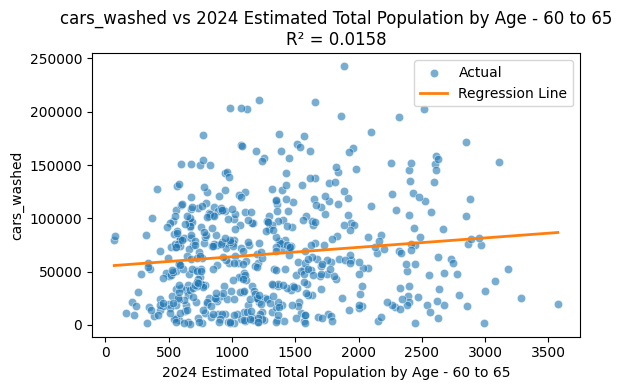

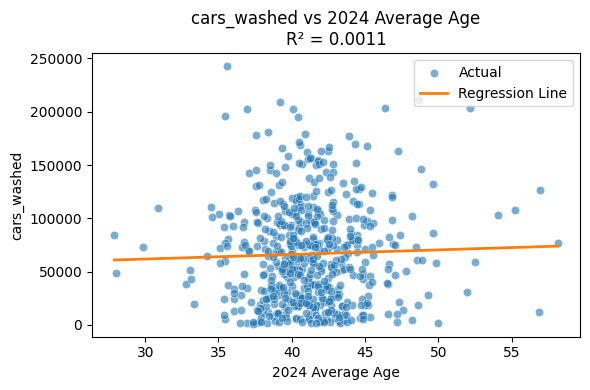

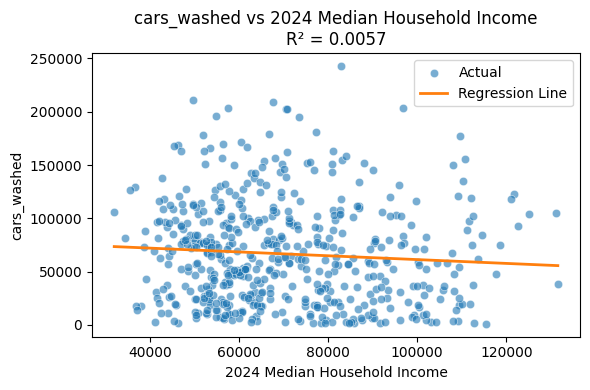

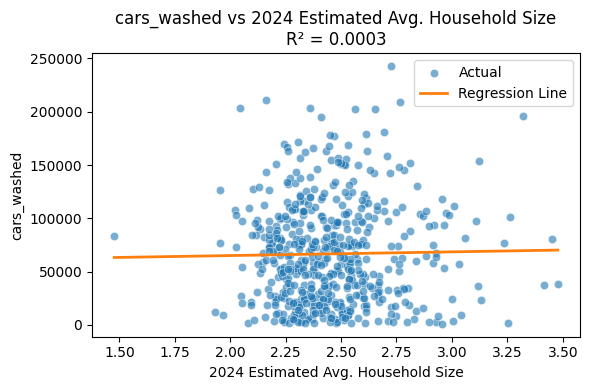

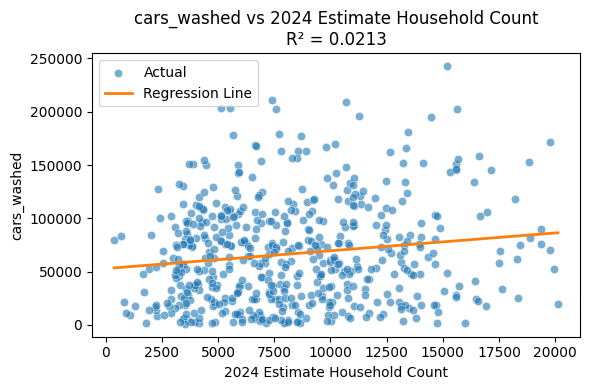

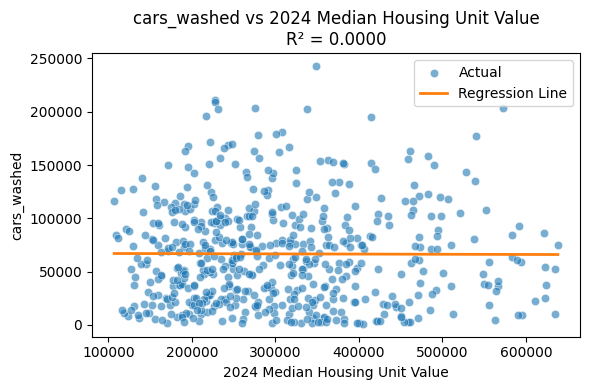

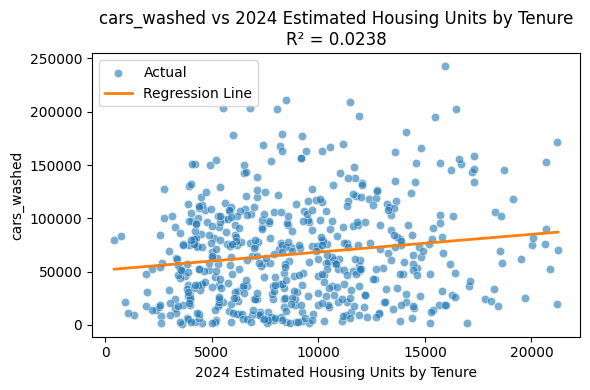

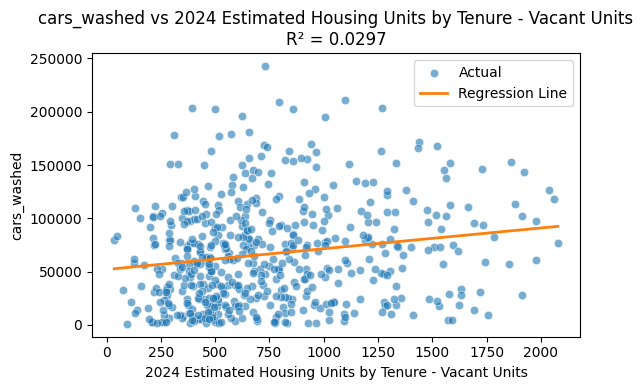

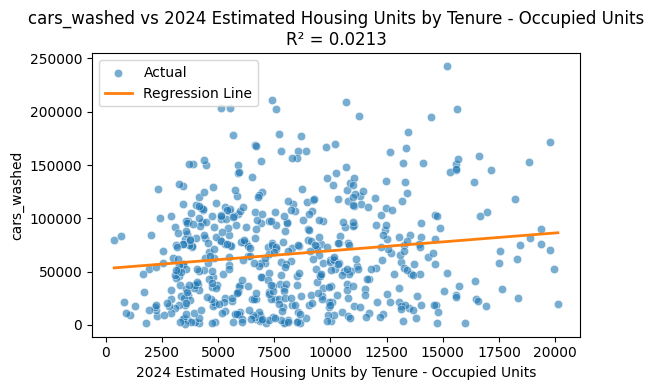

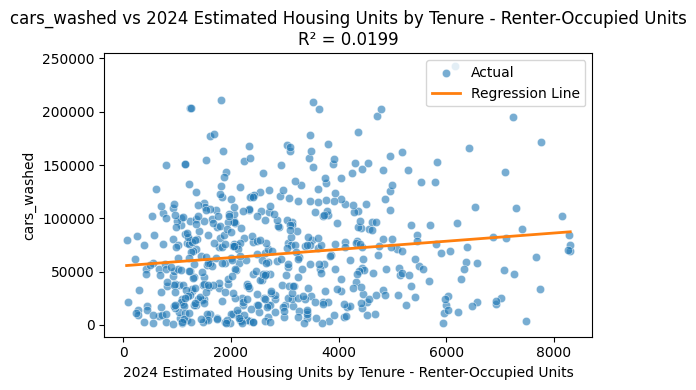

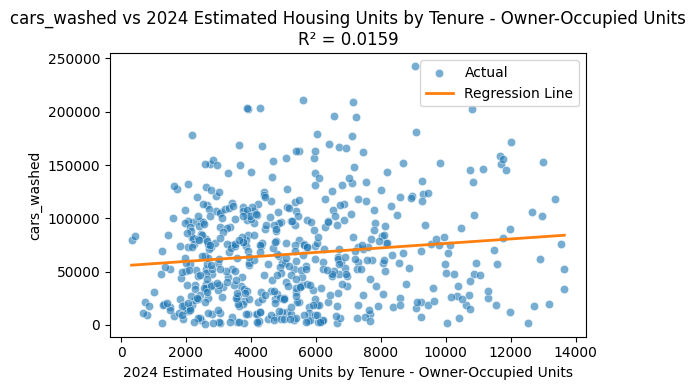

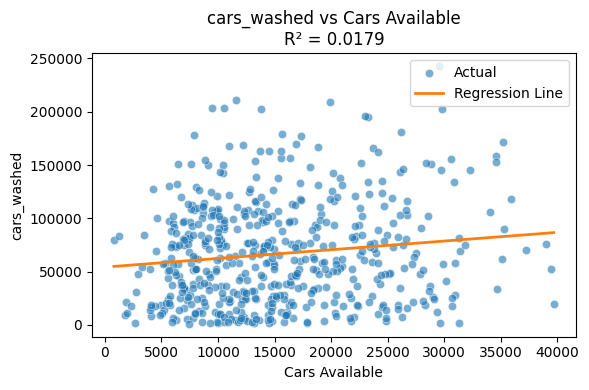

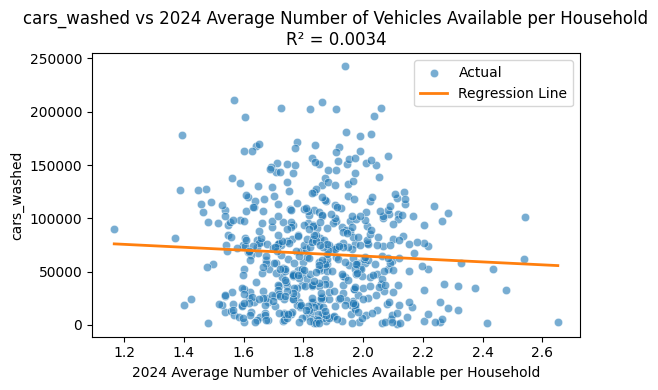

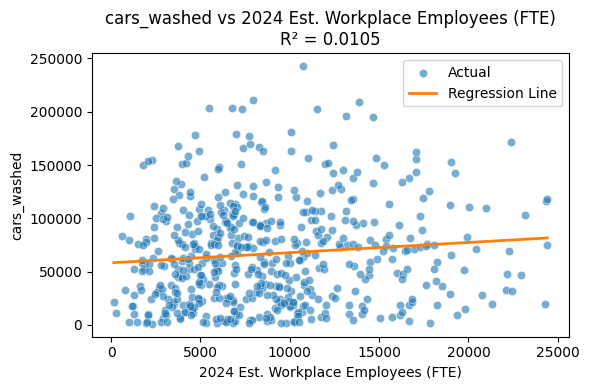

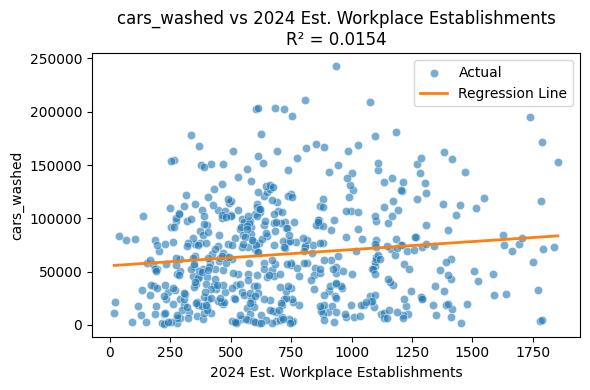

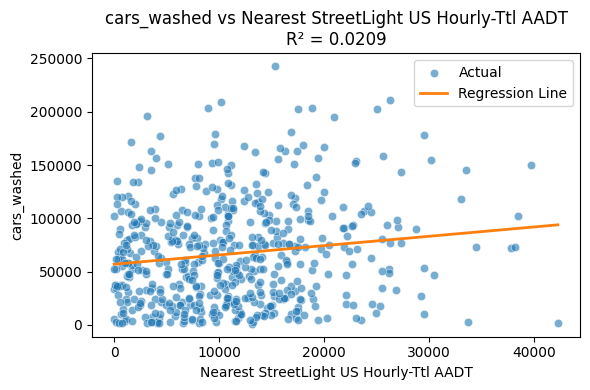

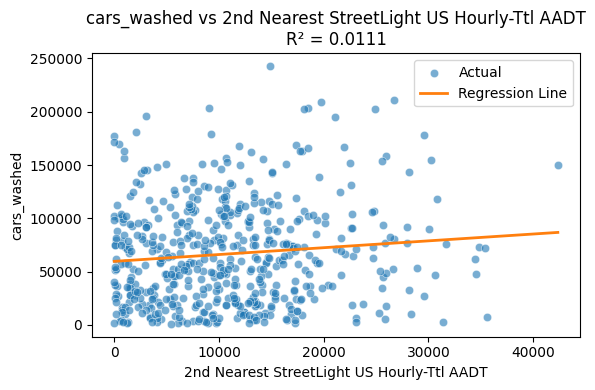

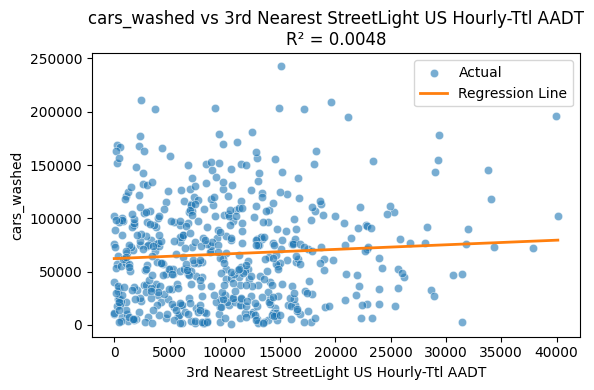

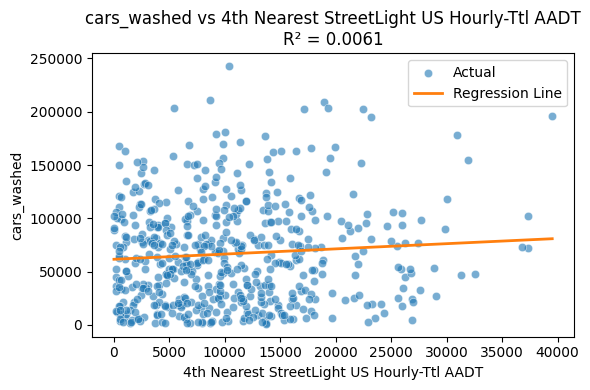

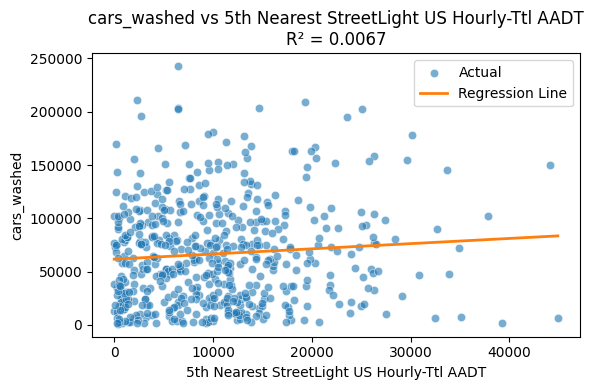

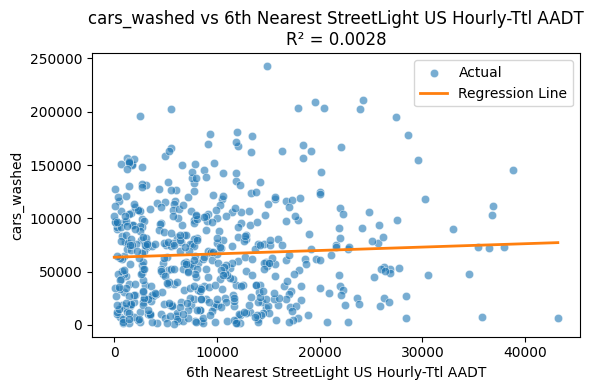

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd

features = [
        '2024 Population Estimate',

        '2024 Estimated Population by Ethnicity - Black',
        '2024 Estimated Population by Ethnicity - Other',
        '2024 Estimated Population by Ethnicity - Asian',
        '2024 Estimated Population by Ethnicity - White',

        'working population 2024',

        '2024 Estimated Total Population by Age - 25 to 30',
        '2024 Estimated Total Population by Age - 30 to 35',
        '2024 Estimated Total Population by Age - 35 to 40',
        '2024 Estimated Total Population by Age - 40 to 45',
        '2024 Estimated Total Population by Age - 45 to 50',
        '2024 Estimated Total Population by Age - 50 to 55',
        '2024 Estimated Total Population by Age - 55 to 60',
        '2024 Estimated Total Population by Age - 60 to 65',

        '2024 Average Age', 
        '2024 Median Household Income',
        '2024 Estimated Avg. Household Size',
        '2024 Estimate Household Count', 
        '2024 Median Housing Unit Value',
        
        '2024 Estimated Housing Units by Tenure',
        '2024 Estimated Housing Units by Tenure - Vacant Units',
        '2024 Estimated Housing Units by Tenure - Occupied Units',
        '2024 Estimated Housing Units by Tenure - Renter-Occupied Units',
        '2024 Estimated Housing Units by Tenure - Owner-Occupied Units', 

        'Cars Available',
        '2024 Average Number of Vehicles Available per Household', 
        '2024 Est. Workplace Employees (FTE)', 
        '2024 Est. Workplace Establishments',

        'Nearest StreetLight US Hourly-Ttl AADT',
        '2nd Nearest StreetLight US Hourly-Ttl AADT',
        '3rd Nearest StreetLight US Hourly-Ttl AADT',
        '4th Nearest StreetLight US Hourly-Ttl AADT',
        '5th Nearest StreetLight US Hourly-Ttl AADT',
        '6th Nearest StreetLight US Hourly-Ttl AADT'
        ]

for feature in features:
    X = df_clean[[feature]]
    y = df_clean["cars_washed"]

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)

    plt.figure(figsize=(6, 4))
    
    sns.scatterplot(x=feature, y="cars_washed", data=df_clean,
                    color='#1f77b4', alpha=0.6, label='Actual')
    
    x_vals = pd.DataFrame(np.linspace(X[feature].min(), X[feature].max(), 100), columns=[feature])
    y_vals = model.predict(x_vals)

    plt.plot(x_vals, y_vals, color='#ff7f0e', linewidth=2, label='Regression Line')

    plt.title(f"cars_washed vs {feature}\nR² = {r2:.4f}")
    plt.xlabel(feature)
    plt.ylabel("cars_washed")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [17]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd

target = "cars_washed"

mi_scores = mutual_info_regression(df_clean[features], df_clean[target], discrete_features=False)

mi_df = pd.DataFrame({"Feature": features, "MI Score": mi_scores})
mi_df = mi_df.sort_values("MI Score", ascending=False)

mi_df

Feature  MI Score
11  2024 Estimated Total Population by Age - 50 to 55  0.087336
15                       2024 Median Household Income  0.083026
33         6th Nearest StreetLight US Hourly-Ttl AADT  0.077195
6   2024 Estimated Total Population by Age - 25 to 30  0.077163
12  2024 Estimated Total Population by Age - 55 to 60  0.076762
0                            2024 Population Estimate  0.075501
13  2024 Estimated Total Population by Age - 60 to 65  0.073099
1      2024 Estimated Population by Ethnicity - Black  0.072313
7   2024 Estimated Total Population by Age - 30 to 35  0.070059
29         2nd Nearest StreetLight US Hourly-Ttl AADT  0.053480
24                                     Cars Available  0.051946
9   2024 Estimated Total Population by Age - 40 to 45  0.036139
2      2024 Estimated Population by Ethnicity - Other  0.035452
5                             working population 2024  0.033731
17                      2024 Estimate Household Count  0.032610
21  2024 Estimated Housing Units by Tenure - Occup...  0.032566
27                 2024 Est. Workplace Establishments  0.030625
8   2024 Estimated Total Population by Age - 35 to 40  0.021415
10  2024 Estimated Total Population by Age - 45 to 50  0.021162
32         5th Nearest StreetLight US Hourly-Ttl AADT  0.020431
23  2024 Estimated Housing Units by Tenure - Owner...  0.017558
4      2024 Estimated Population by Ethnicity - White  0.015911
22  2024 Estimated Housing Units by Tenure - Rente...  0.014845
26                2024 Est. Workplace Employees (FTE)  0.005241
19             2024 Estimated Housing Units by Tenure  0.001238
28             Nearest StreetLight US Hourly-Ttl AADT  0.000000
31         4th Nearest StreetLight US Hourly-Ttl AADT  0.000000
30         3rd Nearest StreetLight US Hourly-Ttl AADT  0.000000
14                                   2024 Average Age  0.000000
25  2024 Average Number of Vehicles Available per ...  0.000000
16                 2024 Estimated Avg. Household Size  0.000000
18                     2024 Median Housing Unit Value  0.000000
3      2024 Estimated Population by Ethnicity - Asian  0.000000
20  2024 Estimated Housing Units by Tenure - Vacan...  0.000000

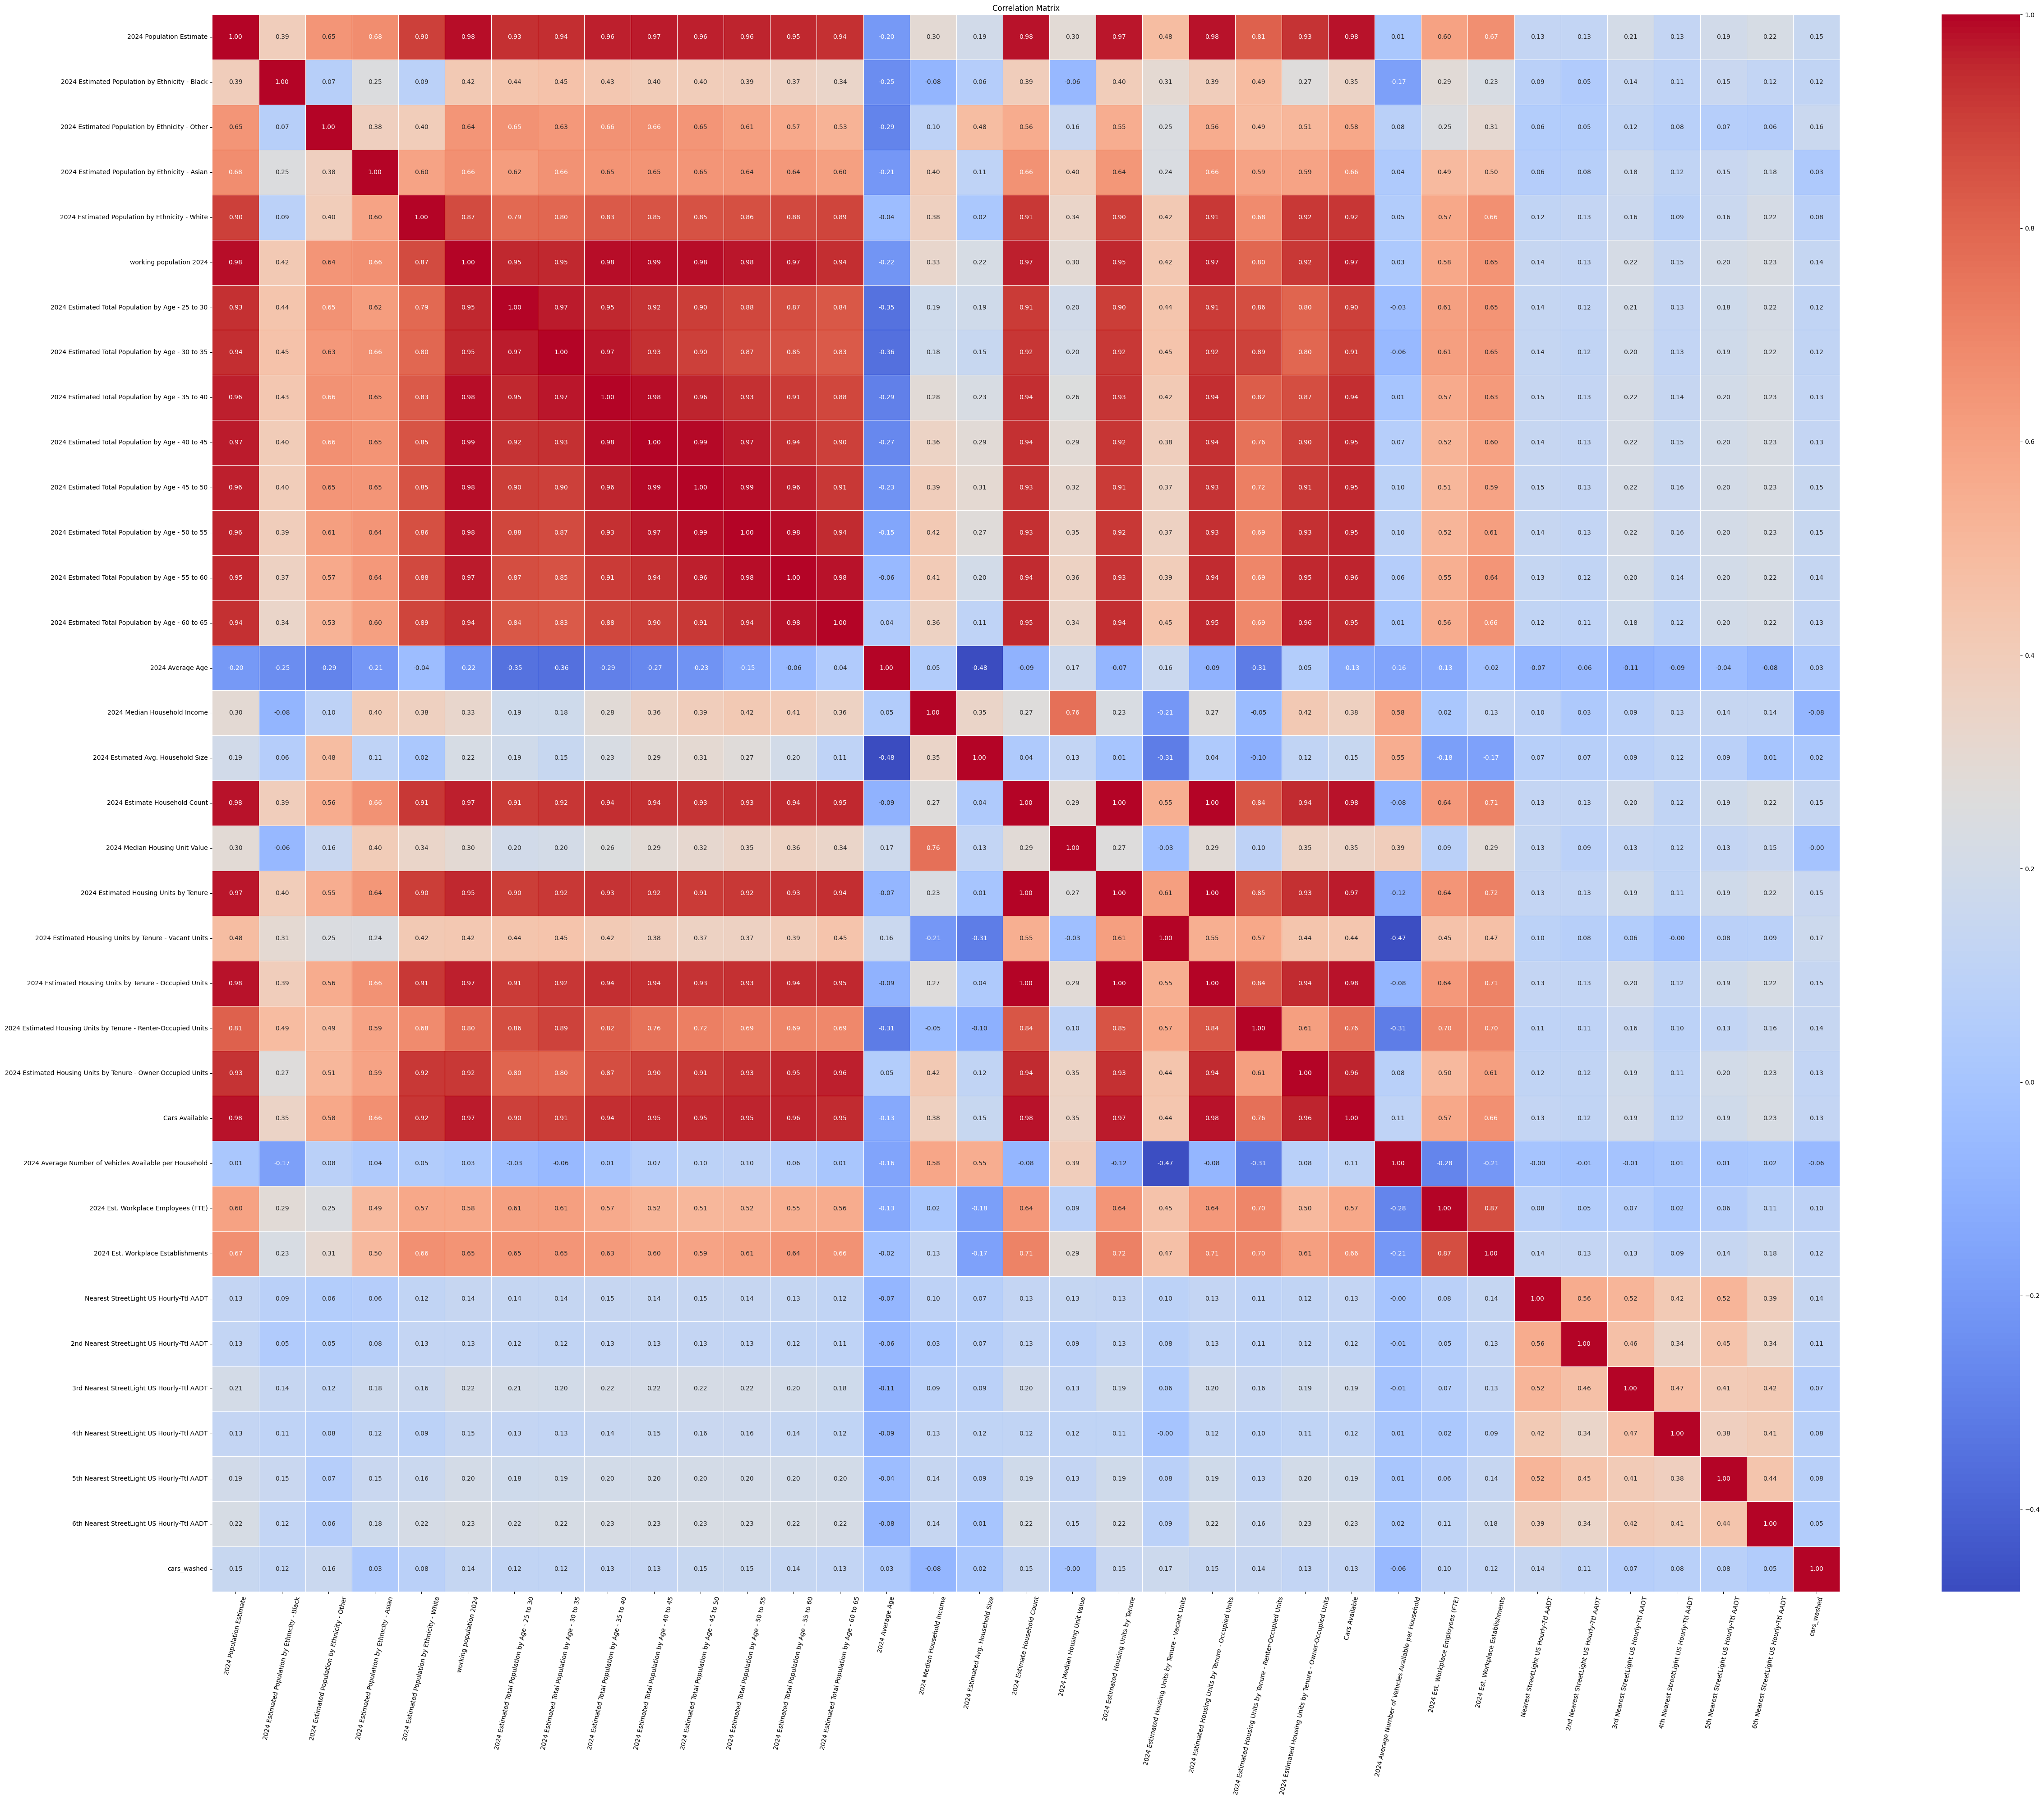

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

target = "cars_washed"

scaler = StandardScaler()
df_clean[features] = scaler.fit_transform(df_clean[features])

correlation_data = df_clean[features + [target]].corr()


plt.figure(figsize=(50, 40))  
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.xticks(rotation=77)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV


target = 'cars_washed'

X = df_clean[features]  
y = df_clean[target]    

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


param_grid = {
    'n_neighbors': range(1, 31),                
    'weights': ['uniform', 'distance'],         
    'p': [1, 2]                                 
}

knn = KNeighborsRegressor()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_knn = grid_search.best_estimator_

y_pred = best_knn.predict(X_test_scaled)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best k (n_neighbors): {grid_search.best_params_['n_neighbors']}")

Best Parameters: {'n_neighbors': 13, 'p': 2, 'weights': 'uniform'}
Best k (n_neighbors): 13


In [20]:
from sklearn.metrics import mean_absolute_error

# Define a threshold (e.g., a prediction is considered 'accurate' if it is within 10% of the actual value)
threshold = 0.15

absolute_percentage_error = abs((y_pred - y_test) / y_test)

accuracy = (absolute_percentage_error <= threshold).mean()


'''The result "Accuracy (within 10%): 9.59%" means that only 9.59% of the predictions made by the KNN model 
are considered "accurate" according to the 10% threshold you set.'''
print(f'Accuracy- KNN (within 15%): {accuracy * 100:.2f}%')

Accuracy- KNN (within 15%): 18.52%


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(y_test, y_pred, model_name, X_test):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)
    n = len(y_test)
    p = X_test.shape[1]
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    print(f"[{model_name}] RMSE: {rmse:.2f}")
    print(f"[{model_name}] MAE: {mae:.2f}")
    print(f"[{model_name}] MAPE: {mape:.2f}%")
    print(f"[{model_name}] R-squared: {r2:.3f}")
    print(f"[{model_name}] Adjusted R-squared: {adj_r2:.3f}")

    # Residuals
    residuals = y_test - y_pred

    # Residual Plot
    plt.figure(figsize=(15, 12))
    
    plt.subplot(2, 2, 1)
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='r', linestyle='--')
    plt.title(f'{model_name} Residuals vs Predicted')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")

    # Predicted vs Actual
    plt.subplot(2, 2, 2)
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title(f'{model_name} Predicted vs Actual')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")


    plt.subplot(2, 2, 4)
    sns.kdeplot(y_test, label='Actual', fill=True, clip=(0, None))
    sns.kdeplot(y_pred, label='Predicted', fill=True, clip=(0, None))
    plt.title(f'{model_name} Distribution: Actual vs Predicted')
    plt.xlabel('cars_washed')
    plt.ylabel('Density')
    plt.legend()

    plt.tight_layout()
    plt.show()

[KNN] RMSE: 46995.12
[KNN] MAE: 36755.50
[KNN] MAPE: 168.37%
[KNN] R-squared: -0.119
[KNN] Adjusted R-squared: -0.640


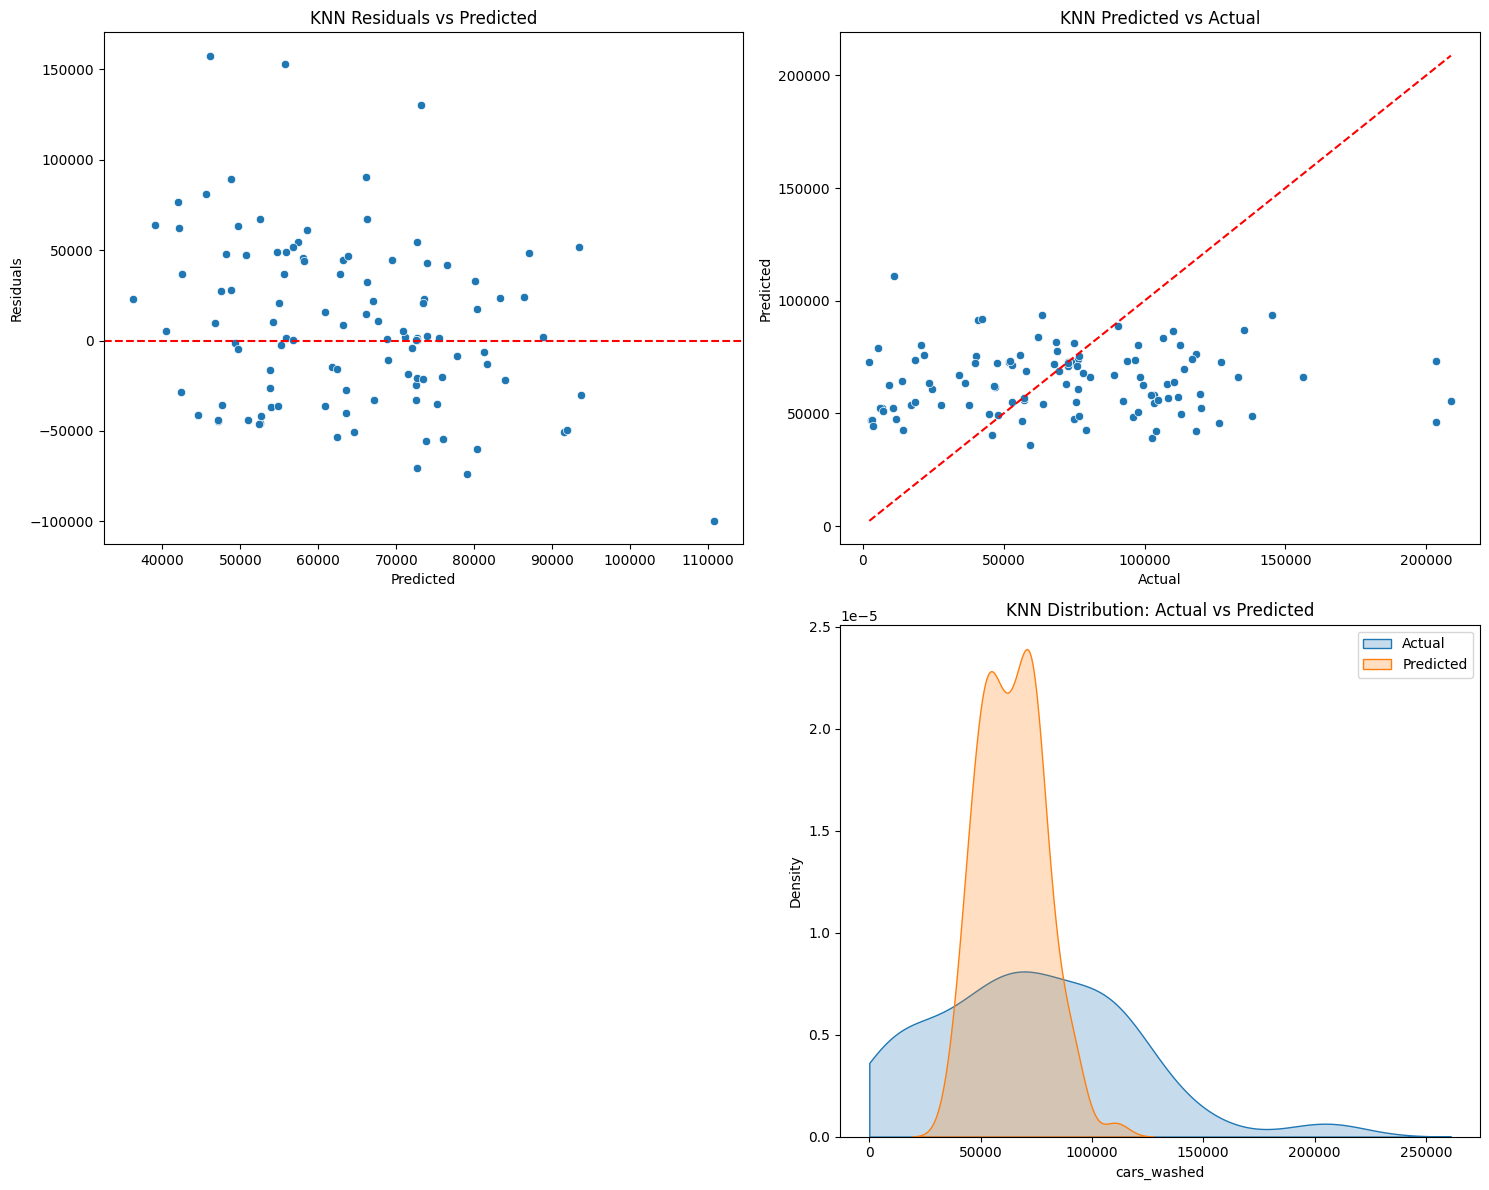

In [22]:
evaluate_model(y_test, y_pred, "KNN", X_test_scaled)

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


X = df_clean[features]
y = df_clean[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)


rf = RandomForestRegressor(random_state=42)


rf_param_grid = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None]  
    
    # 'n_estimators': [100, 200],
    # 'max_depth': [10, 20],
    # 'min_samples_split': [2],
    # 'min_samples_leaf': [1],
    # 'max_features': ['sqrt']
}

rf_grid_search = GridSearchCV(
    rf, rf_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1
)

rf_grid_search.fit(X_train, y_train)
best_rf = rf_grid_search.best_estimator_

y_pred_rf = best_rf.predict(X_test)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [26]:
from sklearn.metrics import mean_absolute_error


threshold = 0.15

absolute_percentage_error_rf = abs((y_pred_rf - y_test) / y_test)

accuracy_rf = (absolute_percentage_error_rf <= threshold).mean()

print(f"Best Parameters: {rf_grid_search.best_params_}")

print(f'Accuracy - Random Forest (within 15%): {accuracy_rf * 100:.2f}%')

Best Parameters: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy - Random Forest (within 15%): 27.78%


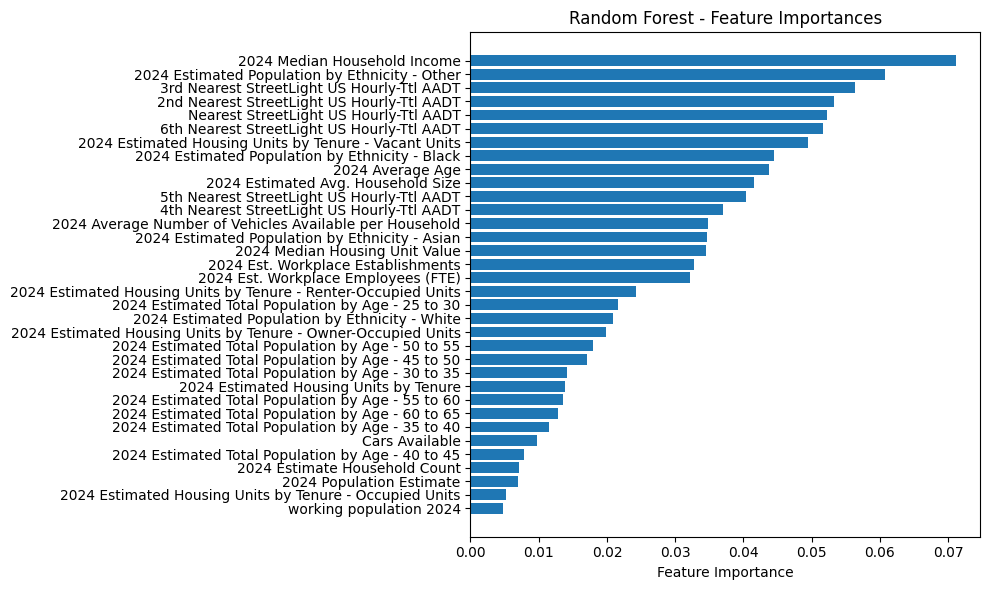

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

importances = best_rf.feature_importances_
feature_names = X.columns  

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

importance_df['Importance'] = importance_df['Importance'].round(4)

importance_df

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Random Forest - Feature Importances")
plt.tight_layout()
plt.show()

[Random Forest] RMSE: 44429.47
[Random Forest] MAE: 33677.75
[Random Forest] MAPE: 172.39%
[Random Forest] R-squared: 0.000
[Random Forest] Adjusted R-squared: -0.465


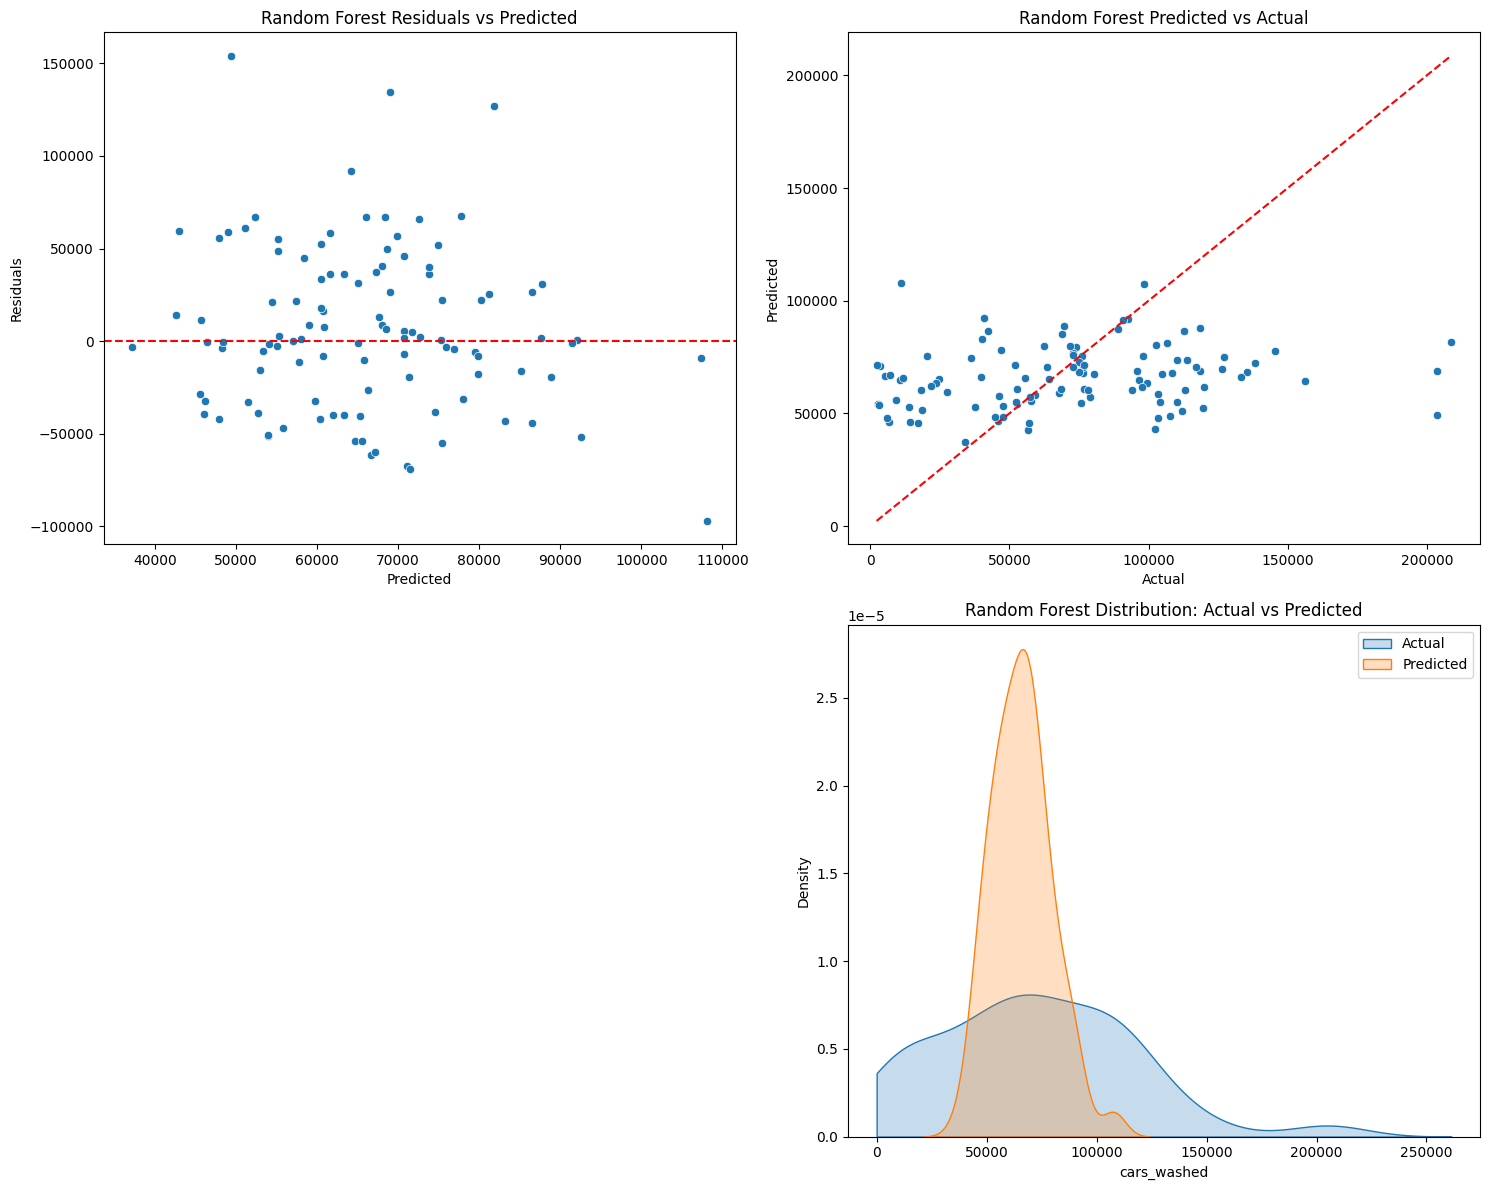

In [28]:
evaluate_model(y_test, y_pred_rf, "Random Forest", X_test_scaled)

In [29]:
!pip3 install xgboost
clear_output()

In [30]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X = df_clean[features]
y = df_clean[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)


xg_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

xgb_param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_grid_search = GridSearchCV(
    xg_reg, xgb_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1
)

xgb_grid_search.fit(X_train, y_train)
best_xgb = xgb_grid_search.best_estimator_

y_pred_xgb = best_xgb.predict(X_test)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [31]:

threshold = 0.15

absolute_percentage_error_xgb = abs((y_pred_xgb - y_test) / y_test)

accuracy_xgb = (absolute_percentage_error_xgb <= threshold).mean()


print(f'Accuracy - XGBoost (within 15%): {accuracy_xgb * 100:.2f}%')

Accuracy - XGBoost (within 15%): 25.00%


[XGBoost] RMSE: 44632.36
[XGBoost] MAE: 34323.91
[XGBoost] MAPE: 172.15%
[XGBoost] R-squared: -0.009
[XGBoost] Adjusted R-squared: -0.479


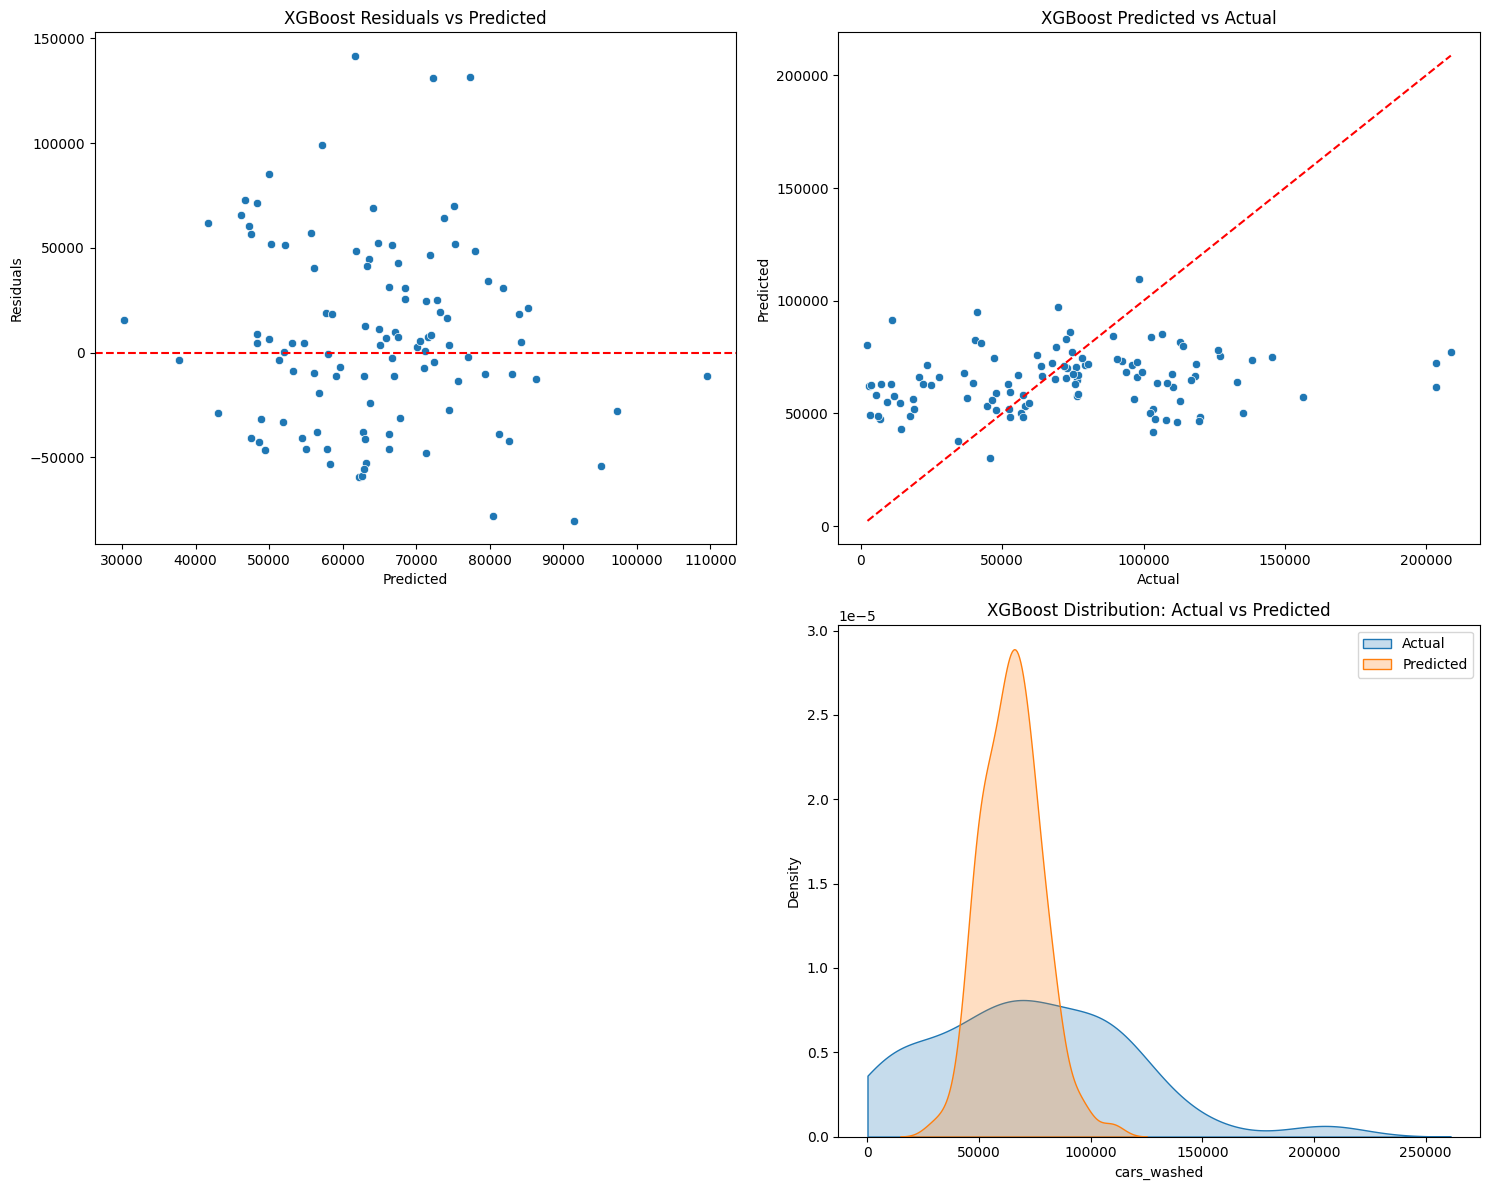

In [32]:
evaluate_model(y_test, y_pred_xgb, "XGBoost", X_test_scaled)

In [33]:
!pip3 install lazypredict
clear_output()

In [34]:
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_clean[features]
y = df_clean[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

models


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4851
[LightGBM] [Info] Number of data points in the train set: 428, number of used features: 34
[LightGBM] [Info] Start training from score 65264.198598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Adjusted R-Squared     R-Squared         RMSE  \
Model                                                                          
RandomForestRegressor                       -0.44          0.02     44031.37   
TweedieRegressor                            -0.46          0.00     44340.51   
BayesianRidge                               -0.46          0.00     44373.44   
ElasticNetCV                                -0.46          0.00     44407.19   
ElasticNet                                  -0.47         -0.00     44444.63   
GradientBoostingRegressor                   -0.47         -0.00     44531.53   
HistGradientBoostingRegressor               -0.47         -0.01     44569.06   
LassoLarsIC                                 -0.47         -0.01     44570.89   
LassoCV                                     -0.48         -0.01     44575.46   
LassoLarsCV                                 -0.48         -0.01     44576.82   
GammaRegressor                              -0.48         -0.01     44586.16   
LarsCV                                      -0.48         -0.01     44622.49   
DummyRegressor                              -0.50         -0.02     44974.33   
BaggingRegressor                            -0.51         -0.03     45083.06   
RidgeCV                                     -0.51         -0.03     45086.59   
AdaBoostRegressor                           -0.52         -0.04     45210.82   
LassoLars                                   -0.52         -0.04     45234.98   
ExtraTreesRegressor                         -0.53         -0.04     45383.96   
SGDRegressor                                -0.53         -0.05     45427.71   
OrthogonalMatchingPursuitCV                 -0.54         -0.05     45605.04   
Ridge                                       -0.55         -0.06     45684.58   
OrthogonalMatchingPursuit                   -0.56         -0.06     45804.61   
NuSVR                                       -0.58         -0.08     46093.41   
LGBMRegressor                               -0.58         -0.08     46113.58   
HuberRegressor                              -0.59         -0.08     46213.99   
Lasso                                       -0.61         -0.10     46511.38   
SVR                                         -0.62         -0.10     46706.31   
QuantileRegressor                           -0.62         -0.11     46715.68   
PassiveAggressiveRegressor                  -0.63         -0.11     46804.83   
PoissonRegressor                            -0.63         -0.11     46815.47   
LinearRegression                            -0.67         -0.14     47362.75   
TransformedTargetRegressor                  -0.67         -0.14     47362.75   
XGBRegressor                                -0.72         -0.18     48177.66   
KNeighborsRegressor                         -0.90         -0.30     50645.68   
ExtraTreeRegressor                          -1.98         -1.03     63384.52   
DecisionTreeRegressor                       -2.01         -1.05     63633.17   
GaussianProcessRegressor                    -3.54         -2.10     78219.53   
KernelRidge                                 -4.27         -2.60     84285.42   
MLPRegressor                                -4.28         -2.60     84325.28   
LinearSVR                                   -4.29         -2.61     84426.70   
RANSACRegressor                             -4.87         -3.01     88943.97   
Lars                                -235711105.60 -160812249.30 563473058.18   

                               Time Taken  
Model                                      
RandomForestRegressor                0.64  
TweedieRegressor                     0.55  
BayesianRidge                        0.57  
ElasticNetCV                         0.03  
ElasticNet                           0.01  
GradientBoostingRegressor            0.45  
HistGradientBoostingRegressor        0.28  
LassoLarsIC                          0.27  
LassoCV                              0.19  
LassoLarsCV               

In [35]:
!pip3 install tabpfn
clear_output()

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tabpfn import TabPFNRegressor
import numpy as np


X = df_clean[features]
y = df_clean[target].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42
)

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

regressor = TabPFNRegressor(device='cpu')
regressor.fit(X_train, y_train)

predictions = regressor.predict(X_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Accuracy (R² Score):", r2)

In [ ]:
threshold = 0.15

y_test_safe = y_test.replace(0, 1e-6)

absolute_percentage_error_tabpfn = abs((predictions - y_test_safe) / y_test_safe)

accuracy_tabpfn = (absolute_percentage_error_tabpfn <= threshold).mean()

print(f'Accuracy - TabPFN (within 15%): {accuracy_tabpfn * 100:.2f}%')